## 1. import

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
from sklearn.model_selection import train_test_split
from collections import Counter
import hanja
from hanja import hangul

In [4]:
# pip install tensorflow

     -------------------------------------- 438.0/438.0 MB 1.7 MB/s eta 0:00:00
     -------------------------------------- 895.7/895.7 KB 2.8 MB/s eta 0:00:00
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     ---------------------------------------- 3.4/3.4 MB 2.8 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
     ---------------------------------------- 1.5/1.5 MB 2.9 MB/s eta 0:00:00
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached libclang-13.0.0

In [2]:
# pip install konlpy

  Using cached konlpy-0.6.0-py2.py3-none-any.whl (19.4 MB)
     -------------------------------------- 362.6/362.6 KB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
# pip install hanja

  Using cached hanja-0.13.3.tar.gz (120 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached PyYAML-5.1.2.tar.gz (265 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for hanja: filename=hanja-0.13.3-py3-none-any.whl size=125964 sha256=571490c464fbd6ddfd94f74e6a54ee2e0055cfa29d0b8ed554dfb590e22a6301
  Stored in directory: c:\users\easya\appdata\local\pip\cache\wheels\98\5c\a3\8f482b30633a7466c0bc9fb748e59b2fdcb67573cf3600c73f
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp39-cp39-win_amd64.whl size=44112 sha256=515fad9dad71f2b33b5032aa1c2793a465c794532c9a81a6b22354cc77c11e85
  Stored in directory: c:\users\easya\appdata\local\pip\cache\wheels\93\72\1b\db6b10e2b46c76704d0eb0716d72091146e539648f6b164bae
Successfully built hanja pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      S

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


## 2. 데이터 불러오기

In [8]:
newsdata = pd.read_csv("../data/Newsfile3.csv", encoding='euc-kr')
newsdata.tail(3)

,date,title
58439,20151019,"[특징주]제주반도체, 美·中 대규모 투자유치에 '上'"
58440,20151019,[반도체] 2016 반도체 투자 감소 예상 - 미래
58441,20151019,"제주반도체, '해외투자유치설' 조회공시 요구"


## 3. 데이터 확인

In [9]:
newsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58442 entries, 0 to 58441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    58442 non-null  int64 
 1   title   58442 non-null  object
dtypes: int64(1), object(1)
memory usage: 913.3+ KB


In [10]:
# 결측치 확인
newsdata.isnull().sum()

date     0
title    0
dtype: int64

## 4. train, test dataset 생성

In [11]:
# train, test set 분리
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(newsdata)

### 4-1. train_data

In [12]:
# train_data 확인
train_data.head(2)

,date,title
5922,20211018,"""車반도체 위기 언제든 재발, 근본 대책 마련해야"""
34496,20190413,"홍남기, 中재정부장 면담…“반도체 반독점 조사ㆍ단체관광 배려 요청”"


In [13]:
# train_data shape 확인
train_data.shape

(43831, 2)

### 4-2. test_data

In [14]:
# test_data 확인
test_data.head(2)

,date,title
15076,20210331,자동차 이어 IT·가전까지… 전방위로 번지는 반도체 공급 대란
282,20220307,러·우크라 사태 반도체 공급망 우려↑… 삼전·SK하이닉스 '동반 하락'


In [15]:
# test_data shape 확인
test_data.shape

(14611, 2)

## 5. 데이터 전처리

### 5-1. train_data

- 한글, 영어, 숫자, 한자 이외의 문자열 제거

In [16]:
train_data["title"] = train_data["title"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣|A-Za-z|一-龥 ]", "")

- 한자가 들어간 데이터 확인

In [17]:
from collections import Counter

In [18]:
train_hanja_data = train_data.copy()

In [19]:
pattern = re.compile('[一-龥]')
# 한자 리스트 확인
hanja_list = train_hanja_data["title"].str.findall(pattern).sum()
# 빈도수가 높은 한자 체크
Counter(hanja_list).most_common()[:5]

[('美', 2092), ('中', 1872), ('車', 1352), ('日', 1096), ('韓', 943)]

In [20]:
# 한자 중복값 제거 확인
new_list = []
for i in hanja_list:
    if i not in new_list:
        new_list.append(i)
print(new_list)

['車', '中', '美', '株', '日', '比', '硏', '韓', '發', '來', '克', '兆', '新', '政', '證', '非', '文', '外', '會', '協', '與', '好', '前', '苦', '高', '史', '亞', '人', '英', '月', '弗', '三', '電', '社', '對', '益', '印', '價', '訪', '力', '企', '獨', '臺', '道', '行', '委', '年', '低', '和', '課', '先', '後', '夢', '大', '無', '佛', '銀', '靑', '孝', '水', '問', '軍', '反', '戰', '全', '乙', '週', '市', '癌', '說', '華', '法', '式', '超', '亂', '民', '官', '恨', '弱', '尹', '稅', '甲', '論', '者', '故', '風', '訴', '業', '産', '純', '功', '逆', '本', '通', '學', '富', '强', '脫', '現', '伊', '枯', '死', '重', '加', '辛', '談', '事', '萬', '公', '種', '難', '西', '安', '告', '上', '名', '家', '氣', '光', '州', '場', '號', '北', '販', '禁', '檢', '洪', '向', '島', '王', '次', '自', '害', '有', '飛', '油', '化', '國', '順', '毒', '選', '濠', '路', '錢', '材', '設', '異', '石', '展', '街', '烹', '裝', '喜', '悲', '多', '曰', '火', '內', '下', '船', '守', '城', '熱', '報', '信', '賞', '災', '星', '鐵', '經', '女', '共', '塞', '翁', '之', '馬', '崔', '母', '投', '心', '燈', '刮', '目', '相', '神', '用']


- `한자 -> 한글로 대체`
    - 뉴스 제목에 사용되는 한자들은 의미를 축약한 한 글자로 구성된 한자가 많은 것으로 추측됨
    - 한자 -> 한글로 단순 번역하는 방법을 시도

In [21]:
train_data["title"] = train_data["title"].apply(lambda x: hanja.translate(x, "substitution"))

In [22]:
train_data.head(3)

,date,title
5922,20211018,차반도체 위기 언제든 재발 근본 대책 마련해야
34496,20190413,홍남기 중재정부장 면담반도체 반독점 조사단체관광 배려 요청
29602,20190815,반도체 소재 등 개 품목 기술개발에 억 조기 투입


### 5-2. test_data

- 한글, 영어, 숫자, 한자 이외의 문자열 제거

In [23]:
test_data["title"] = test_data["title"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣|A-Za-z|一-龥 ]", "")

In [24]:
test_hanja_data = test_data.copy()

In [25]:
pattern = re.compile('[一-龥]')
# 한자 리스트 확인
hanja_list2 = test_hanja_data["title"].str.findall(pattern).sum()
# 빈도수가 높은 한자 체크
Counter(hanja_list2).most_common()[:5]

[('美', 697), ('中', 638), ('車', 469), ('日', 346), ('韓', 335)]

- 한자가 들어간 데이터 확인

In [26]:
# 한자 중복값 제거 확인
new_list = []
for i in hanja_list2:
    if i not in new_list:
        new_list.append(i)
print(new_list)

['硏', '韓', '株', '高', '車', '美', '中', '日', '行', '比', '外', '兆', '證', '好', '文', '三', '電', '全', '克', '訴', '亞', '尹', '親', '發', '對', '新', '獨', '大', '社', '銀', '式', '非', '賞', '來', '靑', '無', '英', '協', '富', '反', '稅', '弗', '價', '內', '企', '故', '訪', '結', '氣', '年', '人', '産', '學', '强', '委', '延', '月', '風', '紙', '油', '化', '朴', '輸', '差', '益', '前', '脫', '臺', '與', '敵', '水', '北', '弱', '向', '居', '安', '思', '危', '戰', '號', '色', '國', '昌', '上', '面', '有', '他', '位', '相', '佛', '事', '萬', '光', '格', '場', '王', '重', '檢', '勝', '談', '用', '說', '市', '苦']


- `한자 -> 한글로 대체`

In [27]:
test_data["title"] = test_data["title"].apply(lambda x: hanja.translate(x, "substitution"))

In [28]:
test_data.head(3)

,date,title
15076,20210331,자동차 이어 IT가전까지 전방위로 번지는 반도체 공급 대란
282,20220307,러우크라 사태 반도체 공급망 우려 삼전SK하이닉스 동반 하락
56453,20160401,삼성전자 지난해 성적표 반도체DPTV휴대전화


## 6. 명사만 추출한 컬럼 추가

- Okt 에러내용 : JVMNotFoundException: No JVM shared library file (jvm.dll) found.
    - 참고 : https://stricky.tistory.com/398

- 오라클 JDK 다운로드 사이트 :  https://www.oracle.com/java/technologies/downloads/#java8

- 설치 경로 확인 > 시스템 환경 변수에 추가 > 변수이름 `JAVA_HOME`으로 저장

In [31]:
# python bit 확인
import platform
print(platform.architecture())

('64bit', 'WindowsPE')


### 6-1. train_data

In [35]:
okt = Okt()
n_ = []
title_rename = []
for i in range(len(train_data)):
    if (i % 2000 == 0):
        print(i, "단계완료")
    n_.append(' '.join(okt.nouns(train_data.iloc[i]["title"])))


# 명사 추출 컬럼 
train_data["nouns"] = n_

# empty space가 아닌 nouns 컬럼만 train_data에 저장
train_data = train_data[train_data["nouns"] != ''] 

0 단계완료
2000 단계완료
4000 단계완료
6000 단계완료
8000 단계완료
10000 단계완료
12000 단계완료
14000 단계완료
16000 단계완료
18000 단계완료
20000 단계완료
22000 단계완료
24000 단계완료
26000 단계완료
28000 단계완료
30000 단계완료
32000 단계완료
34000 단계완료
36000 단계완료
38000 단계완료
40000 단계완료
42000 단계완료


In [36]:
train_data.head(3)

,date,title,nouns
5922,20211018,차반도체 위기 언제든 재발 근본 대책 마련해야,차 반도체 위기 언제 재발 근본 대책 마련
34496,20190413,홍남기 중재정부장 면담반도체 반독점 조사단체관광 배려 요청,홍 중재 정부 면담 반도체 독점 조사 단체 관광 배려 요청
29602,20190815,반도체 소재 등 개 품목 기술개발에 억 조기 투입,반도체 소재 등 개 품목 기술 개발 억 조기 투입


### 6-2. test_data

In [37]:
okt = Okt()
n_ = []
title_rename = []
for i in range(len(test_data)):
    if (i % 2000 == 0):
        print(i, "단계완료")
    n_.append(' '.join(okt.nouns(test_data.iloc[i]["title"])))


# 명사 추출 컬럼 
test_data["nouns"] = n_

# empty space가 아닌 nouns 컬럼만 test_data에 저장
test_data = test_data[test_data["nouns"] != ''] 

0 단계완료
2000 단계완료
4000 단계완료
6000 단계완료
8000 단계완료
10000 단계완료
12000 단계완료
14000 단계완료


In [38]:
test_data.head(3)

,date,title,nouns
15076,20210331,자동차 이어 IT가전까지 전방위로 번지는 반도체 공급 대란,자동차 가전 전방 위로 번지 반도체 공급 대란
282,20220307,러우크라 사태 반도체 공급망 우려 삼전SK하이닉스 동반 하락,러우크 사태 반도체 공급망 우려 삼전 하이닉스 동반 하락
56453,20160401,삼성전자 지난해 성적표 반도체DPTV휴대전화,삼성 전자 지난해 성적표 반도체 휴대전화


## 7. 워드 클라우드

### 7-1. train_data

In [45]:
# train_data > nouns 컬럼 > 0번째 데이터의 단어 출력
train_data.nouns.to_list()[0].split()

['차', '반도체', '위기', '언제', '재발', '근본', '대책', '마련']

In [47]:
# train_data의 길이 확인
len(train_data.nouns.to_list())

43831

In [48]:
nouns_list = []

for i in range(0, len(train_data.nouns.to_list())):
    noun = train_data.nouns.to_list()[i].split()
    nouns_list.append(noun)

In [50]:
nouns_list[:5]

[['차', '반도체', '위기', '언제', '재발', '근본', '대책', '마련'],
 ['홍', '중재', '정부', '면담', '반도체', '독점', '조사', '단체', '관광', '배려', '요청'],
 ['반도체', '소재', '등', '개', '품목', '기술', '개발', '억', '조기', '투입'],
 ['하이닉스', '반도체', '업황', '개선', '목표', '가신'],
 ['삼성', '전자', '깜짝', '실적', '반도체', '값', '계속', '다주', '점진', '상승']]

In [59]:
len(nouns_list)

43831

In [57]:
nouns_list[0]

['차', '반도체', '위기', '언제', '재발', '근본', '대책', '마련']

In [56]:
nouns_list[1]

['홍', '중재', '정부', '면담', '반도체', '독점', '조사', '단체', '관광', '배려', '요청']

In [58]:
nouns_list[0] + nouns_list[1]

['차',
 '반도체',
 '위기',
 '언제',
 '재발',
 '근본',
 '대책',
 '마련',
 '홍',
 '중재',
 '정부',
 '면담',
 '반도체',
 '독점',
 '조사',
 '단체',
 '관광',
 '배려',
 '요청']

In [60]:
sum = []

for i in range(0, len(nouns_list)):
    sum += nouns_list[i]

In [61]:
sum

['차',
 '반도체',
 '위기',
 '언제',
 '재발',
 '근본',
 '대책',
 '마련',
 '홍',
 '중재',
 '정부',
 '면담',
 '반도체',
 '독점',
 '조사',
 '단체',
 '관광',
 '배려',
 '요청',
 '반도체',
 '소재',
 '등',
 '개',
 '품목',
 '기술',
 '개발',
 '억',
 '조기',
 '투입',
 '하이닉스',
 '반도체',
 '업황',
 '개선',
 '목표',
 '가신',
 '삼성',
 '전자',
 '깜짝',
 '실적',
 '반도체',
 '값',
 '계속',
 '다주',
 '점진',
 '상승',
 '삼성',
 '반도체',
 '평택',
 '캠퍼스',
 '삼성',
 '바이오',
 '단지',
 '배후',
 '상권',
 '창',
 '베스트',
 '투자',
 '안전성',
 '확보',
 '포드',
 '반도체',
 '부족',
 '미국',
 '멕시코',
 '공장',
 '일부',
 '생산',
 '중단',
 '가변',
 '반도체',
 '개발',
 '응용',
 '양자',
 '측정',
 '기술',
 '개발',
 '월',
 '수출',
 '급감',
 '개월',
 '감소',
 '반도체',
 '부진',
 '여전',
 '반도체',
 '수급',
 '차질',
 '현대차',
 '아산',
 '공장',
 '일',
 '추가',
 '휴업',
 '하이닉스',
 '조억',
 '투자',
 '청주',
 '최첨단',
 '반도체',
 '공장',
 '건설',
 '권오현',
 '삼성',
 '전자',
 '반도체',
 '기술',
 '찬밥',
 '신세',
 '것',
 '디아',
 '억',
 '규모',
 '반도체',
 '검사',
 '장비',
 '공급',
 '삼성',
 '전자',
 '어닝',
 '서프라이즈',
 '반도체',
 '힘',
 '일진',
 '머티리얼즈',
 '반도체',
 '용',
 '초',
 '박',
 '국산',
 '성공',
 '기지개',
 '편',
 '코스피',
 '선',
 '반도체',
 '인터넷',
 '주',
 '강세',
 '중사',
 '넛크래커',

In [62]:
# 가장 많이 나온 단어 100개 저장
counts = Counter(sum)
tags = counts.most_common(100)

In [71]:
# 워드 클라우드 import
from wordcloud import WordCloud

In [64]:
# pip install wordcloud

     ------------------------------------ 220.7/220.7 KB 613.6 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for wordcloud
Failed to build wordcloud
  Running setup.py install for wordcloud: started
  Running setup.py install for wordcloud: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-3.9
      creating build\lib.win-amd64-3.9\wordcloud
      copying wordcloud\color_from_image.py -> build\lib.win-amd64-3.9\wordcloud
      copying wordcloud\tokenization.py -> build\lib.win-amd64-3.9\wordcloud
      copying wordcloud\wordcloud.py -> build\lib.win-amd64-3.9\wordcloud
      copying wordcloud\wordcloud_cli.py -> build\lib.win-amd64-3.9\wordcloud
      copying wordcloud\_version.py -> build\lib.win-amd64-3.9\wordcloud
      copying wordcloud\__init__.py -> build\lib.win-amd64-3.9\wordcloud
      copying wordcloud\__main__.py -> build\lib.win-amd64-3.9\wordcloud
      copying wordcloud\stopwords -> build\lib.win-amd64-3.9\wordcloud
      copying wordcloud\DroidSansMono.ttf -> build\lib.win-amd64-3.9\wordcloud


- import error 발생
    - `conda install -c conda-forge wordcloud`

- 한글 폰트 사용

In [72]:
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

- 필요없는 단어 제거 - 수동으로 반복처리

In [89]:
import nltk

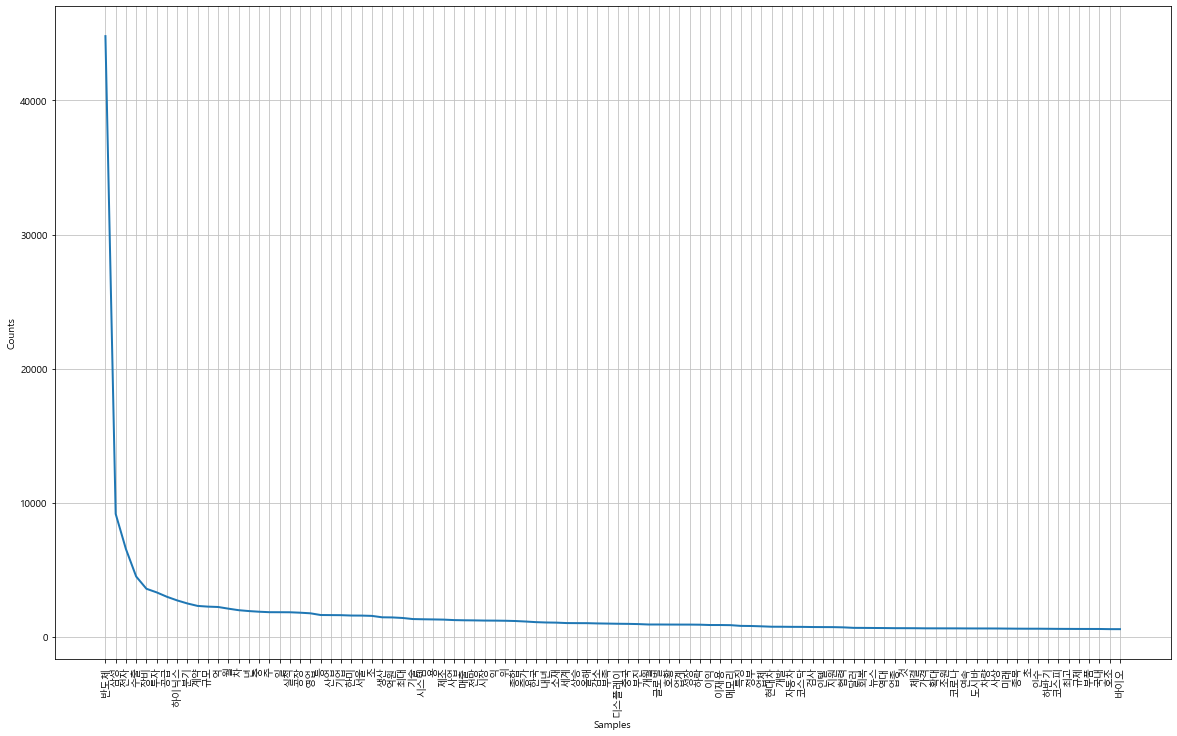

In [98]:
# stop_list 설정 -> 다시 실행시켜 확인해보기: '선물', '추천'이 사라진 것을 볼 수 있다.
words = nltk.Text(sum)
plt.figure(figsize=(20,12))
words.plot(100)        # 많이 사용된 단어 50개를 보여주기
plt.show()

In [101]:
# 불용어 지정
stopwords = "분기 억 월 차 년 중 주 일 등 조 억원 용 익 위 개월 이재용 것 조원 초 하반기"
stop_list = stopwords.split()

# sopt_list에 없는 단어만 추출 > 리스트를 만들 것
words_list = [word for word in sum if sum not in stop_list]

In [102]:
data = words.vocab().most_common(200)
data[:10]

[('반도체', 44793),
 ('삼성', 9166),
 ('전자', 6544),
 ('수출', 4495),
 ('장비', 3581),
 ('투자', 3312),
 ('공급', 2984),
 ('하이닉스', 2713),
 ('분기', 2485),
 ('계약', 2302)]

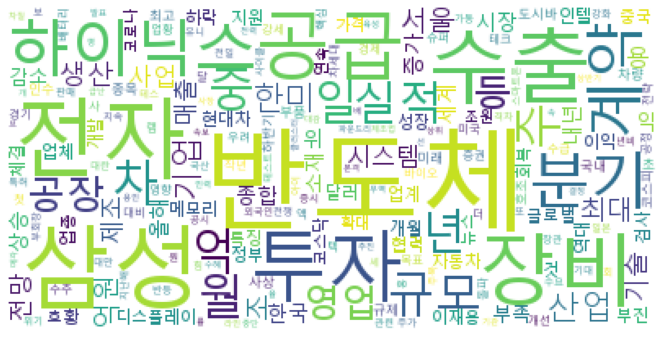

In [103]:
wc = WordCloud(
    font_path='c:/Windows/Fonts/malgun.ttf',
    relative_scaling=0.2, background_color='white'
).generate_from_frequencies(dict(data))

plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis('off')
plt.show()